In [1]:
from google.colab import drive 
drive.mount('/content/drive')  #brings google drive files to be accessible under /content/

Mounted at /content/drive




---
# Load pretrained model


In [2]:
import argparse
import numpy as np
import PIL.Image
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

%tensorflow_version 1.x
import tensorflow as tf
!pip install googledrivedownloader


# Download the code
%cd /content/
!git clone https://github.com/NVlabs/stylegan2.git
%cd /content/stylegan2

!nvcc test_nvcc.cu -o test_nvcc -run

print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

import dnnlib
import dnnlib.tflib as tflib
import pretrained_networks

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content
Cloning into 'stylegan2'...
remote: Enumerating objects: 138, done.
remote: Total 138 (delta 0), reused 0 (delta 0), pack-reused 138
Receiving objects: 100% (138/138), 594.91 KiB | 13.83 MiB/s, done.
Resolving deltas: 100% (64/64), done.
/content/stylegan2
CPU says hello.
GPU says hello.
Tensorflow version: 1.15.2
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-cac5d64d-6e74-ecc1-38fa-3a1e2028f42a)
GPU Identified at: /device:GPU:0


Furry faces pretrained, transfer learn on 5000 anime faces: '/content/drive/My Drive/twist_moe/results/00000-stylegan2-high_res_anime_faces_tfrecords-1gpu-config-f/network-snapshot-000006.pkl'

In [3]:
network_pkl = \
'/content/drive/My Drive/twist_moe/results/00000-stylegan2-high_res_anime_faces_tfrecords-1gpu-config-f/network-snapshot-000006.pkl'
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


Generate images:

In [ ]:
%%capture
# 00002-stylegan2-training_data-1gpu-config-f
# network-snapshot-000000
!python /content/stylegan2/run_generator.py generate-images --seeds=0-100 --truncation-psi=0.7 \
--network='/content/drive/My Drive/twist_moe/results/00000-stylegan2-high_res_anime_faces_tfrecords-1gpu-config-f/network-snapshot-000006.pkl'
#%cp -av /content/stylegan2/results/00000-generate-images /content/drive/'My Drive'/twist_moe/seeds-1.0




---
# .1. Generate and Interpolate images using latent codes


Following code from: Anime StyleGAN2 Google Colab Example

generate_images_from_seeds() -> generate_zs_from_seeds() -> generate_images()
--------

generate_images_from_seeds(): just runs generate_images(generate_zs_from_seeds())

generate_zs_from_seeds(): gets latent vector z from seed #

generate_images(): gets a list of images by running each seed through Gs.run()

In [ ]:
#@title
def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas
   
def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )





In [ ]:
#@title

#other fns (not needed)

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs   

    
def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent    


def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
     
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)

In [ ]:
# generate some random seeds
seeds = np.random.randint(10000000, size=25)
print(seeds)

# show the seeds
imshow(createImageGrid(generate_images_from_seeds(seeds, 0.5), 1 , 5))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Simple (Z) interpolation
zs = generate_zs_from_seeds([ 747737, 5767911 ])

latent1 = zs[0]
latent2 = zs[1]

number_of_steps = 25

imgs = generate_images(interpolate([latent1,latent2],number_of_steps), 1.0)
number_of_images = len(imgs)
imshow(createImageGrid(imgs, 0.7 , 5))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from IPython import display as ipythondisplay
import io
import os
import base64
from IPython.display import HTML

def show_video(vid):
  #mp4list = [video
  #if len(mp4list) > 0:
  ext = os.path.splitext(vid)[-1][1:]
  video = io.open(vid, 'r+b').read()
  #encoded = base64.b64encode(video)
  ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
              loop controls style="height: 400px;">
              <source src="data:video/{1}';base64,{0}" type="video/{1}" />
              </video>'''.format(base64.b64encode(video).decode('ascii'), ext)))
  
# Example using lib 'imageio' of reading a generated set of images, and storing as MP4.
%mkdir out
movieName = 'out/mov_anime.mp4'
with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))
show_video(movieName)

mkdir: cannot create directory ‘out’: File exists




---
# .2. Project an image using StyleGAN encoder then generate

From: https://colab.research.google.com/github/halcy/AnimeFaceNotebooks/blob/master/colab/Stylegan2_Playground.ipynb

Project an image through an (inverse generator?), then pass the code through this trained StyleGAN variation to get that image in the style of this StyleGAN variation.

In [ ]:
import run_projector
import projector
proj = projector.Projector()  
proj.set_network(Gs)  #inverse generator?

In [ ]:
##
# Projection - encoding images into latent space
##
import copy

# Projects an image into dlatent space and returns the dlatents
def encode_image(image, steps=1000, verbose=True):
    image_processed = np.array(copy.deepcopy(image).convert('RGB').resize((512, 512), resample = PIL.Image.LANCZOS)) / 255.0
    image_processed = (image_processed.transpose(2, 0, 1) - 0.5) * 2.0
    image_processed = np.array([image_processed])
    proj.num_steps = steps
    proj.start(image_processed)
    while proj.get_cur_step() < steps:
        if verbose:
            print('\rProjection: Step %d / %d ... ' % (proj.get_cur_step(), steps), end='', flush=True)
        proj.step()
    print('\r', end='', flush=True)
    return proj.get_dlatents()

In [ ]:
# Init randomizer, load latents
rnd = np.random # Could seed here if you want to
latents_a = rnd.randn(1, Gs.input_shape[1])
latents_b = rnd.randn(1, Gs.input_shape[1])
latents_c = rnd.randn(1, Gs.input_shape[1])

In [ ]:
##
# Plain generation
##
import math
import numpy.linalg as la

# We have to do truncation ourselves, since we're not using the combined network
def truncate(dlatents, truncation_psi, maxlayer = 16):
    dlatent_avg = tf.get_default_session().run(Gs.own_vars["dlatent_avg"])
    layer_idx = np.arange(16)[np.newaxis, :, np.newaxis]
    ones = np.ones(layer_idx.shape, dtype=np.float32)
    coefs = tf.where(layer_idx < maxlayer, truncation_psi * ones, ones)
    return tf.get_default_session().run(tflib.lerp(dlatent_avg, dlatents, coefs))

# Generate image with disentangled latents as input
def generate_images_from_dlatents(dlatents, truncation_psi = 1.0, randomize_noise = True):
    if not truncation_psi is None:
        dlatents_trunc = truncate(dlatents, truncation_psi)
    else:
        dlatents_trunc = dlatents
        
    # Run the network
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    result_image = Gs.components.synthesis.run(
        dlatents_trunc.reshape((-1, 16, 512)),
        randomize_noise = randomize_noise,
        minibatch_size = 1,
        output_transform=fmt
    )[0]
    return result_image

In [ ]:
#@title
# # "Ellipse around a point but probably a circle since it's 512 dimensions" laten
# def circ_generator(latents_interpolate):
#     radius = 40.0

#     latents_axis_x = (latents_a - latents_b).flatten() / la.norm(latents_a - latents_b)
#     latents_axis_y = (latents_a - latents_c).flatten() / la.norm(latents_a - latents_c)

#     latents_x = math.sin(math.pi * 2.0 * latents_interpolate) * radius
#     latents_y = math.cos(math.pi * 2.0 * latents_interpolate) * radius

#     latents = latents_a + latents_x * latents_axis_x + latents_y * latents_axis_y
#     return latents

# # Generate images from a list of latents
# def generate_from_latents(latent_list, truncation_psi):
#     array_list = []
#     image_list = []
#     for latents in latent_list:
#         # Generate image.
#         fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
#         images = Gs.run(latents, None, truncation_psi=truncation_psi, randomize_noise=False, output_transform=fmt)
#         array_list.append(images[0])
#         image_list.append(PIL.Image.fromarray(images[0], 'RGB'))
        
#     return array_list, image_list

# def mse(x, y):
#     return (np.square(x - y)).mean()

# # Generate from a latent generator, keeping MSE between frames constant
# def generate_from_generator_adaptive(gen_func):
#     max_step = 1.0
#     current_pos = 0.0
    
#     change_min = 10.0
#     change_max = 11.0
    
#     fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    
#     current_latent = gen_func(current_pos)
#     current_image = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
#     array_list = []
    
#     while(current_pos < 1.0):
#         array_list.append(current_image)
        
#         lower = current_pos
#         upper = current_pos + max_step
#         current_pos = (upper + lower) / 2.0
        
#         current_latent = gen_func(current_pos)
#         current_image = images = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
#         current_mse = mse(array_list[-1], current_image)
        
#         while current_mse < change_min or current_mse > change_max:
#             if current_mse < change_min:
#                 lower = current_pos
#                 current_pos = (upper + lower) / 2.0
            
#             if current_mse > change_max:
#                 upper = current_pos
#                 current_pos = (upper + lower) / 2.0
                
            
#             current_latent = gen_func(current_pos)
#             current_image = images = Gs.run(current_latent, None, truncation_psi=0.5, randomize_noise=False, output_transform=fmt)[0]
#             current_mse = mse(array_list[-1], current_image)
#         print(current_pos, current_mse)
        
#     return array_list

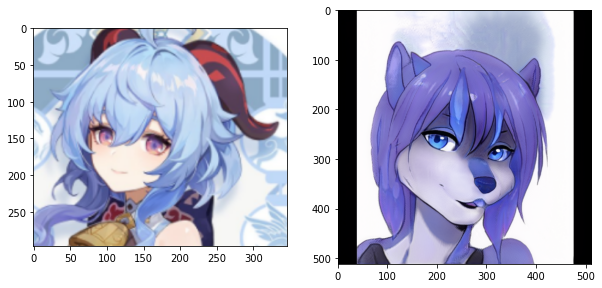

In [ ]:
# Note that projection has a random component - if you're not happy with the result, probably retry a few times
# For best results, probably have a single person facing the camera with a neutral white background
# Replace "input.png" with your own image if you want to use something other than toshiko koshijima, however unlikely this may be

import matplotlib.pyplot as plt

# even if img finishes uploading on drive, may take few mins before colab is updated on file change
# don't use webp file
input_url = "/content/drive/MyDrive/ganyu.png"
num_encode_steps = 100

def show_projected_image(input_url, num_encode_steps):
    image = PIL.Image.open(input_url)
    proj_dlatents = encode_image(image, num_encode_steps)

    image_projected = generate_images_from_dlatents(proj_dlatents, 0.4)
    plt.figure(figsize=(10, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(np.array(image))
    plt.subplot(1, 2, 2)
    plt.imshow(image_projected)

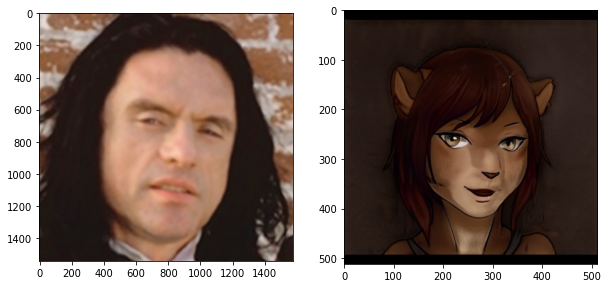

In [ ]:
show_projected_image('/content/drive/MyDrive/Tommy-Wiseau-1.jpg', num_encode_steps)



---


# LASSO [WIP]

In [ ]:
##
# Modification - prepararing data for training dlatent dirs
##

# Generate samples to pass to the tagger model
def generate_one_for_latentdirs(truncation_psi = 0.7, randomize_noise = True):
    latents = rnd.randn(1, Gs.input_shape[1])
    dlatents = Gs.components.mapping.run(latents, None)[0]
    dlatents_trunc = truncate(dlatents, truncation_psi)
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    result_image = Gs.components.synthesis.run(
        dlatents_trunc.reshape((-1, 16, 512)),
        randomize_noise = randomize_noise,
        minibatch_size = 1,
        output_transform=fmt
    )[0]
    return latents, dlatents, result_image

# This gets slower as we go so lets go in steps of 100 to see if that alleviates the issue
# of course, this doesn't work, on account of my GPU memory being too small. minibatch 10, maybe?
# I want a ti 2080 11gb quite badly
def generate_many_for_latentdirs(truncation_psi = 0.7, randomize_noise = True):
    latents = rnd.randn(100, Gs.input_shape[1])
    dlatents = Gs.components.mapping.run(latents, None)
    dlatents_trunc = truncate(dlatents, truncation_psi)
    fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    result_image = Gs.components.synthesis.run(
        dlatents_trunc.reshape((-1, 16, 512)),
        randomize_noise = randomize_noise,
        minibatch_size = 10,
        output_transform=fmt
    )
    return latents, dlatents, result_image

In [ ]:
# Unfortunately, stylegan 2 only runs on tf 1.14, while deepdanbooru current uses tf 2 - so we just save images here
# and tag them later (see DeepDanbooru-Playground notebook)

import glob
import pickle
import time

latent_list = []
dlatent_list = []
image_list = []
image_count = 104000 # Increment to resume
while True:
    tags_exist = set(map(lambda x: x.split("_")[-1], glob.glob("image_tags_*")))
    tags_required = set(map(lambda x: x.split("_")[-1], glob.glob("dlatents_for_tagging_*")))
    tags_todo = sorted(list(tags_required.difference(tags_exist)))
    
    if len(tags_todo) > 0:
        print("Waiting for tagger, resuming in 120s, queue depth:", len(tags_todo))  #stuck on this
        time.sleep(120)
    else:
        # Vary psi a little
        psi = 0.7
        if len(image_list) < 200:
            psi = 0.5
        if len(image_list) < 500:
            psi = 0.6

        latents, dlatents, image = generate_many_for_latentdirs(truncation_psi = psi)
        latent_list.extend(latents)
        dlatent_list.extend(dlatents)
        image_list.extend(image)
        #if len(image_list) % 100 == 0:
        print(".")

        image_count += 100
        if image_count % 1000 == 0:
            with open("dlatents_for_tagging_{}.pkl".format(image_count), 'wb') as f:
                pickle.dump((latent_list, dlatent_list, image_list), f)
            print("Wrote", "dlatents_for_tagging_{}.pkl".format(image_count))
            latent_list = []
            dlatent_list = []
            image_list = []

.
.
.
.
.
.
.
.
.
.
Wrote dlatents_for_tagging_105000.pkl
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, queue depth: 1
Waiting for tagger, resuming in 120s, que

KeyboardInterrupt: ignored

ISSUE: waiting for tagger. reqs another colab nb?


---
# .3. Find new directions with SeFA [WIP]

https://colab.research.google.com/github/mchong6/GANsNRoses/blob/main/inference_colab.ipynb#scrollTo=1SnBuXtzQAK2




In [ ]:
%%capture
#@title

!git clone https://github.com/mchong6/GANsNRoses.git
%cd GANsNRoses
!pip install tqdm gdown kornia scipy opencv-python dlib moviepy lpips aubio ninja

import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms, utils
from tqdm import tqdm
torch.backends.cudnn.benchmark = True
import copy
from util import *
from PIL import Image

from model import *
import moviepy.video.io.ImageSequenceClip
import scipy
import cv2
import dlib
import kornia.augmentation as K
from aubio import tempo, source

from IPython.display import HTML
from base64 import b64encode
from google.colab import files


In [ ]:
device = 'cuda'
latent_dim = 8
n_mlp = 5
num_down = 3

G_A2B = Generator(256, 4, latent_dim, n_mlp, channel_multiplier=1, lr_mlp=.01,n_res=1).to(device).eval()

ensure_checkpoint_exists('GNR_checkpoint.pt')
ckpt = torch.load('GNR_checkpoint.pt', map_location=device)

G_A2B.load_state_dict(ckpt['G_A2B_ema'])

Check if furry_tf_anime NN is same data structure as GANsNRoses's G_A2B = Generator(). No- furry_tf_anime is tf, G_A2B is torch

In [ ]:
Gs

In [ ]:
G_A2B

In [ ]:
modulate = {
    k: v
    for k, v in ckpt["G_A2B_ema"].items()
    if "modulation" in k and "to_rgbs" not in k and "weight" in k
}

weight_mat = []
for k, v in modulate.items():
    weight_mat.append(v)

W = torch.cat(weight_mat, 0)
eigvec = torch.svd(W).V.to("cpu")



---
# .4. Compare activations of images with few factors changed [WIP]

The 'compare activations' functions we used were for the classifier. For generator, we must modify them not to see what probabilities are outputted.

In [ ]:
# import copy

# top_neurons_dict = {} # (image, layer) : top X neurons

# # need to create new fn b/c activation hook set before sending image thru model
# def get_activations(layer_name, zs, truncation_psi):
#     activation = {}
#     def get_activation(name):
#         def hook(model, input, output):
#             activation[name] = output.detach()
#         return hook

#     Gs_kwargs = dnnlib.EasyDict()
#     Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
#     Gs_kwargs.randomize_noise = False
#     if not isinstance(truncation_psi, list):
#         truncation_psi = [truncation_psi] * len(zs)
        
#     imgs = []
#     for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
#         Gs_kwargs.truncation_psi = truncation_psi[z_idx]
#         noise_rnd = np.random.RandomState(1) # fix noise
#         tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
#         images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
#         imgs.append(PIL.Image.fromarray(images[0], 'RGB'))

#     for name_to_check, layer in model.named_modules():
#         if name_to_check == layer_name:
#             break
#     layer.register_forward_hook(get_activation(layer_name))
#     output = model(input_batch)
#     return activation.copy()  #else will return the same actvs of model

In [ ]:
def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    # return generate_images(generate_zs_from_seeds(seeds), truncation_psi)
    return get_activations(generate_zs_from_seeds(seeds), truncation_psi)


In [ ]:
# generate some random seeds
seeds = np.random.randint(10000000, size=2)
print(seeds)

psi = 0.5

# show the seeds
# imshow(createImageGrid(generate_images_from_seeds(seeds, 0.5), 1 , 5))

generate_images_from_seeds(seeds, psi)

[1920727 3707076]


[<PIL.Image.Image image mode=RGB size=512x512 at 0x7FF2AA434150>,
 <PIL.Image.Image image mode=RGB size=512x512 at 0x7FF2AA4483D0>]

ISSUE: The trained networks are not compatible with previous code that used model = models.googlenet(pretrained=True). Again, this is because the pretrained model is TENSORFLOW, but your previous code is torch.

In [4]:
Gs

In [ ]:
named_layers = dict(Gs.named_modules())
layers = list(named_layers.keys())

AttributeError: ignored

In [5]:
layer_names=[layer.name for layer in Gs.layers]

AttributeError: ignored

In [9]:
Gs.list_layers()

[('latents_in',
  <tf.Tensor 'Gs/latents_in:0' shape=(?, 512) dtype=float32>,
  []),
 ('labels_in', <tf.Tensor 'Gs/labels_in:0' shape=(?, 0) dtype=float32>, []),
 ('lod', <tf.Tensor 'Gs/lod/ReadVariableOp:0' shape=() dtype=float32>, []),
 ('dlatent_avg',
  <tf.Tensor 'Gs/dlatent_avg/ReadVariableOp:0' shape=(512,) dtype=float32>,
  []),
 ('G_mapping/latents_in',
  <tf.Tensor 'Gs/G_mapping/latents_in:0' shape=(?, 512) dtype=float32>,
  []),
 ('G_mapping/labels_in',
  <tf.Tensor 'Gs/G_mapping/labels_in:0' shape=(?, 0) dtype=float32>,
  []),
 ('G_mapping/Dense0',
  <tf.Tensor 'Gs/G_mapping/Dense0/IdentityN:0' shape=(?, 512) dtype=float32>,
  [<tf.Variable 'G_mapping_1/Dense0/weight:0' shape=(512, 512) dtype=float32>,
   <tf.Variable 'G_mapping_1/Dense0/bias:0' shape=(512,) dtype=float32>]),
 ('G_mapping/Dense1',
  <tf.Tensor 'Gs/G_mapping/Dense1/IdentityN:0' shape=(?, 512) dtype=float32>,
  [<tf.Variable 'G_mapping_1/Dense1/weight:0' shape=(512, 512) dtype=float32>,
   <tf.Variable 'G_mapp